# 1 训练数据

## 1.1 数据集代码实现

In [1]:
import math
import numpy as np
import torch
from torch.utils.data import Dataset

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ToyDataset(Dataset):
    def __init__(self, size: int, stdev: float, random_state: int = None):
        self.size = size
        self.noise = stdev
        self.random_state = random_state
        self.stdev = self._calc_stdev()
        self.data = self._sample()
        
    def _calc_stdev(self):
        pass

    def _sample(self):
        pass

    def resample(self):
        self.data = self._sample()

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return torch.from_numpy(self.data[idx])

In [3]:
class Gaussian25(ToyDataset):
    scale = 2
    modes = [(i, j) for i in range(-2, 3) for j in range(-2, 3)]

    def __init__(self, size, stdev=0.05, random_state=1234):
        self.modes = self.scale * np.array(self.modes, dtype=np.float32)
        super(Gaussian25, self).__init__(size, stdev, random_state)

    def _calc_stdev(self):
        # x-y symmetric; around 2.828
        return math.sqrt(self.noise ** 2 + (self.scale ** 2) * 2.)  

    def _sample(self):
        rng = np.random.default_rng(self.random_state)
        data = self.noise * rng.standard_normal((self.size, 2), dtype=np.float32)
        data += np.array(self.modes)[np.arange(self.size) % 25]
        data /= self.stdev
        return data

In [4]:
class DataStreamer:
    def __init__(self, dataset: ToyDataset, batch_size: int, num_batches: int, resample: bool = False):
        dataset = self.dataset_map(dataset)
        self.batch_size = batch_size
        self.num_batches = num_batches
        self.resample = resample
        self.dataset = dataset(batch_size * num_batches, random_state=None)

    def __iter__(self):
        cnt = 0
        while True:
            start = cnt * self.batch_size
            end = start + self.batch_size
            yield torch.from_numpy(self.dataset.data[start:end])
            cnt += 1
            if cnt >= self.num_batches:
                break
        if self.resample:
            self.dataset.resample()

    def __len__(self):
        return self.num_batches
        
    @staticmethod
    def dataset_map(dataset):
        return {
            "gaussian25": Gaussian25,
        }.get(dataset, None)

## 1.2 Gaussian25数据集可视化

Gaussian25由25个高斯分布组合而成，每个样本是一个2d点（每个点从任意一个高斯分布采样得到），所以可视化结果是整个Gaussian25数据集（即整个数据集的分布）。

注意：样本是图中的点，而非整张图。

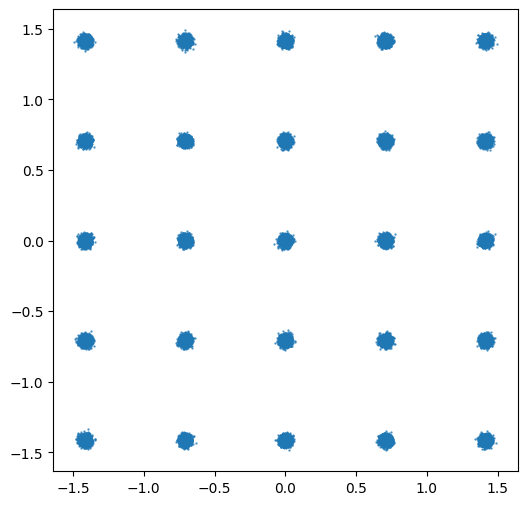

In [5]:
import matplotlib.pyplot as plt

dataset = Gaussian25(100000)
plt.figure(figsize=(6, 6))
plt.scatter(*np.hsplit(dataset.data, 2), s=0.5, alpha=0.7)

# 2 模型

## 2.1 Timestep Embedding

与tranformer中的Position Embedding相同，此处使用正弦、余弦函数编码扩散步数timestep。

In [6]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

DEFAULT_DTYPE = torch.float32

In [7]:
def get_timestep_embedding(timesteps, embed_dim: int, dtype: torch.dtype = DEFAULT_DTYPE):
    """
    Adapted from fairseq/fairseq/modules/sinusoidal_positional_embedding.py
    The implementation is slightly different from the decription in Section 3.5 of [1]
    [1] Vaswani, Ashish, et al. "Attention is all you need."
     Advances in neural information processing systems 30 (2017).
    """
    half_dim = embed_dim // 2
    embed = math.log(10000) / (half_dim - 1)
    embed = torch.exp(-torch.arange(half_dim, dtype=dtype, device=timesteps.device) * embed)
    embed = torch.outer(timesteps.ravel().to(dtype), embed)
    embed = torch.cat([torch.sin(embed), torch.cos(embed)], dim=1)
    if embed_dim % 2 == 1:
        embed = F.pad(embed, [0, 1])  # padding the last dimension
    assert embed.dtype == dtype
    return embed

## 2.2 去噪模型

* 输入：加噪（扩散）样本$x_t$，扩散步数t
* 输出：样本x中的噪声$\epsilon$

In [8]:
DEFAULT_NORMALIZER = nn.LayerNorm
DEFAULT_NONLINEARITY = nn.LeakyReLU(negative_slope=0.02, inplace=True)


class Sequential(nn.Sequential):
    def forward(self, input, **kwargs):
        for module in self:
            input = module(input, **kwargs)
        return input


class TemporalLayer(nn.Module):
    normalize = DEFAULT_NORMALIZER
    nonlinearity = DEFAULT_NONLINEARITY

    def __init__(self, in_features, out_features, temporal_features):
        super(TemporalLayer, self).__init__()
        self.norm1 = self.normalize(in_features)
        self.fc1 = nn.Linear(in_features, out_features, bias=False)
        self.norm2 = self.normalize(out_features)
        self.fc2 = nn.Linear(out_features, out_features, bias=False)
        self.enc = nn.Linear(temporal_features, out_features)

        self.skip = nn.Identity() if in_features == out_features else nn.Linear(in_features, out_features, bias=False)

    def forward(self, x, t_emb):
        out = self.fc1(self.nonlinearity(self.norm1(x)))
        out += self.enc(t_emb)
        out = self.fc2(self.nonlinearity(self.norm2(out)))
        skip = self.skip(x)
        return out + skip
    

class Decoder(nn.Module):
    normalize = DEFAULT_NORMALIZER
    nonlinearity = DEFAULT_NONLINEARITY

    def __init__(self, in_features, mid_features, num_temporal_layers):
        super(Decoder, self).__init__()

        self.in_fc = nn.Linear(in_features, mid_features, bias=False)
        self.temp_fc = Sequential(*([TemporalLayer(
            mid_features, mid_features, mid_features), ] * num_temporal_layers))
        self.out_norm = self.normalize(mid_features)
        self.out_fc = nn.Linear(mid_features, in_features)
        self.t_proj = Sequential(
            nn.Linear(mid_features, mid_features),
            self.nonlinearity)
        self.mid_features = mid_features

    def forward(self, x, t):
        t_emb = get_timestep_embedding(t, self.mid_features)
        t_emb = self.t_proj(t_emb)
        out = self.in_fc(x)
        out = self.temp_fc(out, t_emb=t_emb)
        out = self.out_fc(self.out_norm(out))
        return out

In [9]:
test_model = Decoder(2, 128, 2)
print(test_model, flush=True)
out = test_model(torch.randn(16, 2), t=torch.randint(1000, size=(16, )))
print(out.shape)

Decoder(
  (in_fc): Linear(in_features=2, out_features=128, bias=False)
  (temp_fc): Sequential(
    (0): TemporalLayer(
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=128, out_features=128, bias=False)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (fc2): Linear(in_features=128, out_features=128, bias=False)
      (enc): Linear(in_features=128, out_features=128, bias=True)
      (skip): Identity()
    )
    (1): TemporalLayer(
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=128, out_features=128, bias=False)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (fc2): Linear(in_features=128, out_features=128, bias=False)
      (enc): Linear(in_features=128, out_features=128, bias=True)
      (skip): Identity()
    )
  )
  (out_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (out_fc): Linear(in_features=128, out_featu

## 2.3 扩散模型

In [10]:
class GaussianDiffusion:
    def __init__(self, betas, device='cuda:0', **kwargs):
        assert isinstance(betas, torch.Tensor) and betas.dtype == torch.float64
        assert (betas > 0).all() and (betas <= 1).all()
        self.betas = betas
        self.timesteps = len(betas)
        self.device=device

        alphas = 1 - betas
        self.alphas_bar = torch.cumprod(alphas, dim=0)
        alphas_bar_prev = torch.cat([torch.as_tensor([1., ], dtype=torch.float64), self.alphas_bar[:-1]])

        # q(x_t | x_0)
        self.sqrt_alphas_bar = torch.sqrt(self.alphas_bar)
        self.sqrt_one_minus_alphas_bar = torch.sqrt(1. - self.alphas_bar)

        # q(x_{t-1} | x_t, x_0)
        sqrt_alphas_bar_prev = torch.sqrt(alphas_bar_prev)
        self.sqrt_recip_alphas_bar = torch.sqrt(1. / self.alphas_bar)
        self.sqrt_recip_m1_alphas_bar = torch.sqrt(1. / self.alphas_bar - 1.)  # m1: minus 1
        self.posterior_var = betas * (1. - alphas_bar_prev) / (1. - self.alphas_bar)
        self.posterior_logvar_clipped = torch.log(torch.cat([self.posterior_var[[1]], self.posterior_var[1:]]))
        self.posterior_mean_coef1 = betas * sqrt_alphas_bar_prev / (1. - self.alphas_bar)
        self.posterior_mean_coef2 = torch.sqrt(alphas) * (1. - alphas_bar_prev) / (1. - self.alphas_bar)

        # for fixed model_var_type's
        self.fixed_model_var = self.betas
        self.fixed_model_logvar = torch.log(torch.cat([self.posterior_var[[1]], self.betas[1:]]))

    @staticmethod
    def _extract(
            arr, t, x,
            dtype=torch.float32, device=torch.device("cpu"), ndim=4):
        if x is not None:
            dtype = x.dtype
            device = x.device
            ndim = x.ndim
        out = torch.as_tensor(arr, dtype=dtype, device=device).gather(0, t)
        return out.reshape((-1, ) + (1, ) * (ndim - 1))

    def q_sample(self, x_0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_0)
        coef1 = self._extract(self.sqrt_alphas_bar, t, x_0)
        coef2 = self._extract(self.sqrt_one_minus_alphas_bar, t, x_0)
        return coef1 * x_0 + coef2 * noise

    def q_posterior_mean_var(self, x_0, x_t, t):
        posterior_mean_coef1 = self._extract(self.posterior_mean_coef1, t, x_0)
        posterior_mean_coef2 = self._extract(self.posterior_mean_coef2, t, x_0)
        posterior_mean = posterior_mean_coef1 * x_0 + posterior_mean_coef2 * x_t
        posterior_var = self._extract(self.posterior_var, t, x_0)
        posterior_logvar = self._extract(self.posterior_logvar_clipped, t, x_0)
        return posterior_mean, posterior_var, posterior_logvar

    def _pred_x_0_from_eps(self, x_t, eps, t):
        coef1 = self._extract(self.sqrt_recip_alphas_bar, t, x_t)
        coef2 = self._extract(self.sqrt_recip_m1_alphas_bar, t, x_t)
        return coef1 * x_t - coef2 * eps

    def p_mean_var(self, denoise_fn, x_t, t, clip_denoised, return_pred):
        out = denoise_fn(x_t, t)

        model_var, model_logvar = self._extract(self.fixed_model_var, t, x_t),\
                                  self._extract(self.fixed_model_logvar, t, x_t)

        # calculate the mean estimate
        _clip = (lambda x: x.clamp(-1., 1.)) if clip_denoised else (lambda x: x)
        pred_x_0 = _clip(self._pred_x_0_from_eps(x_t=x_t, eps=out, t=t))
        model_mean, *_ = self.q_posterior_mean_var(x_0=pred_x_0, x_t=x_t, t=t)
        
        if return_pred:
            return model_mean, model_var, model_logvar, pred_x_0
        else:
            return model_mean, model_var, model_logvar

    # === sample ===
    def p_sample_step(self, denoise_fn, x_t, t, clip_denoised=True, return_pred=False, generator=None):
        model_mean, _, model_logvar, pred_x_0 = self.p_mean_var(
            denoise_fn, x_t, t, clip_denoised=clip_denoised, return_pred=True)
        noise = torch.empty_like(x_t).normal_(generator=generator)
        nonzero_mask = (t > 0).reshape((-1,) + (1,) * (x_t.ndim - 1)).to(x_t)
        sample = model_mean + nonzero_mask * torch.exp(0.5 * model_logvar) * noise
        return (sample, pred_x_0) if return_pred else sample

    @torch.inference_mode()
    def p_sample(self, denoise_fn, shape=None, noise=None, seed=None):
        device = self.device
        B = (shape or noise.shape)[0]
        t = torch.empty((B, ), dtype=torch.int64, device=device)
        rng = None
        if seed is not None:
            rng = torch.Generator(device).manual_seed(seed)
        if noise is None:
            x_t = torch.empty(shape, device=device).normal_(generator=rng)
        else:
            x_t = noise.to(device)
        for ti in range(self.timesteps - 1, -1, -1):
            t.fill_(ti)
            x_t = self.p_sample_step(denoise_fn, x_t, t, generator=rng)
        return x_t

    # train
    def train_losses(self, denoise_fn, x_0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_0)
        
        # add noise
        x_t = self.q_sample(x_0, t, noise=noise)

        # predict noise and get loss
        target = noise
        model_out = denoise_fn(x_t, t)
        losses = torch.mean((target - model_out).pow(2), dim=1)
        
        return losses

In [11]:
class Toy2dGaussianDiffusion(GaussianDiffusion):
    def p_mean_var(self, denoise_fn, x_t, t, clip_denoised, return_pred):
        out = denoise_fn(x_t, t)

        model_var, model_logvar = self._extract(self.fixed_model_var, t, x_t),\
                                  self._extract(self.fixed_model_logvar, t, x_t)

        # calculate the mean estimate
        _clip = lambda x: x
        pred_x_0 = _clip(self._pred_x_0_from_eps(x_t=x_t, eps=out, t=t))
        model_mean, *_ = self.q_posterior_mean_var(x_0=pred_x_0, x_t=x_t, t=t)

        if return_pred:
            return model_mean, model_var, model_logvar, pred_x_0
        else:
            return model_mean, model_var, model_logvar

# 3 训练

## 3.1 模型、数据及$\beta$初始化

In [12]:
import torch
from tqdm import tqdm

In [13]:
def _warmup_beta(beta_start, beta_end, timesteps, warmup_frac, dtype):
    betas = beta_end * torch.ones(timesteps, dtype=dtype)
    warmup_time = int(timesteps * warmup_frac)
    betas[:warmup_time] = torch.linspace(beta_start, beta_end, warmup_time, dtype=dtype)
    return betas


def get_beta_schedule(beta_schedule, beta_start, beta_end, timesteps, dtype=torch.float64):
    if beta_schedule == 'quad':
        betas = torch.linspace(beta_start ** 0.5, beta_end ** 0.5, timesteps, dtype=dtype) ** 2
    elif beta_schedule == 'linear':
        betas = torch.linspace(beta_start, beta_end, timesteps, dtype=dtype)
    elif beta_schedule == 'warmup10':
        betas = _warmup_beta(beta_start, beta_end, timesteps, 0.1, dtype=dtype)
    elif beta_schedule == 'warmup50':
        betas = _warmup_beta(beta_start, beta_end, timesteps, 0.5, dtype=dtype)
    elif beta_schedule == 'const':
        betas = beta_end * torch.ones(timesteps, dtype=dtype)
    elif beta_schedule == 'jsd':  # 1/T, 1/(T-1), 1/(T-2), ..., 1
        betas = 1. / torch.linspace(timesteps, 1, timesteps, dtype=dtype)
    else:
        raise NotImplementedError(beta_schedule)
    assert betas.shape == (timesteps, )
    return betas

In [14]:
bsize = 1000
num_batch = 100
train_dataloader = DataStreamer('gaussian25', bsize, num_batch)

beta_schedule = 'linear'
beta_start = 0.001
beta_end = 0.2
timesteps = 100
betas = get_beta_schedule(beta_schedule, beta_start, beta_end, timesteps)

diffusion_model = Toy2dGaussianDiffusion(betas)

in_features = 2
min_features = 128
num_temporal_layers = 2
denoise_model = Decoder(in_features, min_features, num_temporal_layers).cuda()

## 3.2 训练过程

In [15]:
def train_step(diffusion_model, denoise_model, optimizer, x):
    B = x.shape[0]
    T = diffusion_model.timesteps
    
    # get loss
    t = torch.randint(T, size=(B, ), dtype=torch.int64).cuda()
    loss = diffusion_model.train_losses(denoise_model, x_0=x, t=t)
    assert loss.shape == (B, )
    loss = loss.mean()

    # loss backward
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    return loss.item() * B

In [16]:
def train(diffusion_model, denoise_model, trainloader, optimizer, epochs):
    for e in range(epochs):        
        with tqdm(trainloader, desc=f"{e + 1}/{epochs} epochs", ncols=100) as t:
            sum_loss = 0

            denoise_model.train()
            for i, x in enumerate(t):
                loss = train_step(diffusion_model, denoise_model, optimizer, x.cuda())
                sum_loss += loss
            print('loss: {:.6f}'.format(sum_loss/len(t)))

In [17]:
from torch.optim import Adam

epochs = 100
optimizer = Adam(denoise_model.parameters(), lr=0.001, betas=(0.9, 0.999))

train(diffusion_model, denoise_model, train_dataloader, optimizer, epochs)

1/100 epochs: 100%|██████████████████████████████████████████████| 100/100 [00:00<00:00, 115.30it/s]


loss: 338.778409


2/100 epochs: 100%|██████████████████████████████████████████████| 100/100 [00:00<00:00, 292.69it/s]


loss: 267.999909


3/100 epochs: 100%|██████████████████████████████████████████████| 100/100 [00:00<00:00, 294.63it/s]


loss: 266.061410


4/100 epochs: 100%|██████████████████████████████████████████████| 100/100 [00:00<00:00, 293.99it/s]


loss: 260.898340


5/100 epochs: 100%|██████████████████████████████████████████████| 100/100 [00:00<00:00, 294.25it/s]


loss: 257.085062


6/100 epochs: 100%|██████████████████████████████████████████████| 100/100 [00:00<00:00, 294.41it/s]


loss: 254.610623


7/100 epochs: 100%|██████████████████████████████████████████████| 100/100 [00:00<00:00, 294.81it/s]


loss: 252.987005


8/100 epochs: 100%|██████████████████████████████████████████████| 100/100 [00:00<00:00, 294.88it/s]


loss: 251.562274


9/100 epochs: 100%|██████████████████████████████████████████████| 100/100 [00:00<00:00, 294.51it/s]


loss: 242.814696


10/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 289.38it/s]


loss: 244.615830


11/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 294.54it/s]


loss: 240.943040


12/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 294.94it/s]


loss: 242.961718


13/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 295.09it/s]


loss: 239.517501


14/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 295.11it/s]


loss: 239.419972


15/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 295.30it/s]


loss: 234.945767


16/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 294.98it/s]


loss: 232.744032


17/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 294.17it/s]


loss: 233.506818


18/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 295.26it/s]


loss: 231.637966


19/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 290.89it/s]


loss: 229.042316


20/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 295.21it/s]


loss: 228.408165


21/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 294.85it/s]


loss: 229.683099


22/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 294.86it/s]


loss: 227.395040


23/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 292.52it/s]


loss: 227.931915


24/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 293.56it/s]


loss: 224.169152


25/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 294.21it/s]


loss: 222.978022


26/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 294.17it/s]


loss: 225.219888


27/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 290.24it/s]


loss: 227.278029


28/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 294.63it/s]


loss: 221.499660


29/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 293.93it/s]


loss: 220.579336


30/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 294.26it/s]


loss: 223.056766


31/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 293.66it/s]


loss: 224.579577


32/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 294.28it/s]


loss: 219.959004


33/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 294.71it/s]


loss: 220.739950


34/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 294.36it/s]


loss: 222.282832


35/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 294.06it/s]


loss: 220.358627


36/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 289.32it/s]


loss: 220.991017


37/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 294.15it/s]


loss: 224.549747


38/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 294.00it/s]


loss: 220.556516


39/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 294.14it/s]


loss: 220.341061


40/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 294.12it/s]


loss: 218.263849


41/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 293.86it/s]


loss: 218.457348


42/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 293.35it/s]


loss: 220.781883


43/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 293.94it/s]


loss: 222.173794


44/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 293.87it/s]


loss: 218.246616


45/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 291.19it/s]


loss: 219.866573


46/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 294.14it/s]


loss: 218.041740


47/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 294.07it/s]


loss: 219.551271


48/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 293.36it/s]


loss: 218.623346


49/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 293.62it/s]


loss: 216.569862


50/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 294.23it/s]


loss: 216.988705


51/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 294.22it/s]


loss: 220.084108


52/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 294.00it/s]


loss: 219.096896


53/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 293.63it/s]


loss: 216.971192


54/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 294.00it/s]


loss: 217.130910


55/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 292.93it/s]


loss: 217.425685


56/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 293.95it/s]


loss: 219.631201


57/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 294.55it/s]


loss: 212.244994


58/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 294.47it/s]


loss: 216.556564


59/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 294.41it/s]


loss: 215.451837


60/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 291.97it/s]


loss: 218.385769


61/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 290.73it/s]


loss: 221.338072


62/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 293.87it/s]


loss: 216.390254


63/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 293.73it/s]


loss: 215.459444


64/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 294.32it/s]


loss: 219.659590


65/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 294.38it/s]


loss: 217.082581


66/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 294.58it/s]


loss: 216.605276


67/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 291.22it/s]


loss: 218.372605


68/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 293.08it/s]


loss: 218.339259


69/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 294.59it/s]


loss: 216.669519


70/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 294.37it/s]


loss: 218.131049


71/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 295.03it/s]


loss: 217.719897


72/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 294.87it/s]


loss: 215.268220


73/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 294.33it/s]


loss: 217.286645


74/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 293.79it/s]


loss: 214.637719


75/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 294.48it/s]


loss: 214.800183


76/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 294.42it/s]


loss: 218.046833


77/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 294.50it/s]


loss: 217.692618


78/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 294.97it/s]


loss: 219.654678


79/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 293.83it/s]


loss: 216.659244


80/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 292.23it/s]


loss: 216.359575


81/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 291.49it/s]


loss: 214.982379


82/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 291.53it/s]


loss: 217.207503


83/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 292.64it/s]


loss: 216.541489


84/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 293.25it/s]


loss: 219.170279


85/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 291.28it/s]


loss: 217.125795


86/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 292.18it/s]


loss: 216.560617


87/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 292.15it/s]


loss: 215.163518


88/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 288.36it/s]


loss: 218.439725


89/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 291.43it/s]


loss: 216.911026


90/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 293.02it/s]


loss: 214.886618


91/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 293.91it/s]


loss: 214.105494


92/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 293.89it/s]


loss: 214.525399


93/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 293.88it/s]


loss: 218.413192


94/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 293.97it/s]


loss: 213.924145


95/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 293.67it/s]


loss: 214.815985


96/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 293.32it/s]


loss: 217.649692


97/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 293.49it/s]


loss: 218.119261


98/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 293.34it/s]


loss: 215.028778


99/100 epochs: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 292.79it/s]


loss: 214.631223


100/100 epochs: 100%|████████████████████████████████████████████| 100/100 [00:00<00:00, 293.21it/s]

loss: 217.981727


## 3.3 采样并可视化

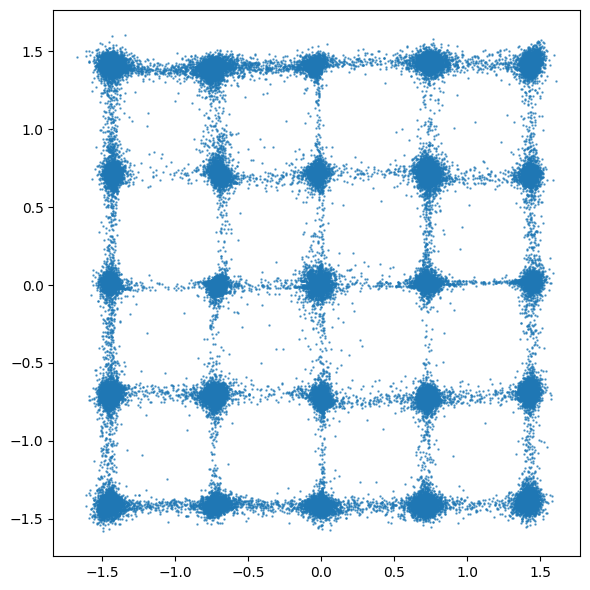

In [18]:
import matplotlib.pyplot as plt

def split_squeeze(data):
    x, y = np.split(data, 2, axis=1)
    x, y = x.squeeze(1), y.squeeze(1)
    return x, y

def scatter_plot(x, y=None, xlim=None, ylim=None):
    if hasattr(x, "ndim"):
        x, y = split_squeeze(x) if x.ndim == 2 else (np.arange(len(x)), x)
    plt.figure(figsize=(6, 6))
    plt.scatter(x, y, s=0.5, alpha=0.7)

    # set axes limits
    if xlim is not None:
        plt.xlim(*xlim)
    if ylim is not None:
        plt.ylim(*ylim)

    plt.tight_layout()

sample = diffusion_model.p_sample(denoise_model, (100000, 2))
scatter_plot(sample.cpu())